# Routes Optimization from Avignon Warehouse

In [1]:
import pandas as pd
import time

In [2]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [3]:
factors = pd.read_csv('factors.csv')
routes = pd.read_csv('routes_v2.csv')
cities = pd.read_csv('cities.csv')
orders = pd.read_csv('orders.csv')
pack = pd.read_csv('packages.csv')
price = pd.read_csv('pricing.csv')
trucks = pd.read_csv('trucks.csv')
wareh = pd.read_csv('warehouses.csv')

In [4]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calcule la distance en kilomètres entre deux points (lon1, lat1) et (lon2, lat2) 
    sur une sphère (la Terre) en utilisant la formule de Haversine.
    """
    # Conversion des latitudes et longitudes en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Calcul des différences de latitude et de longitude
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Calcul de la distance en kilomètres
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

# Initialisation du dataframe 'distance' avec les noms de villes en index et en colonnes
disti = pd.DataFrame(index=cities['city'], columns=cities['city'])

# Calcul de la distance en kilomètres entre chaque paire de villes
for i in cities.index:
    for j in cities.index:
        disti.loc[cities.loc[i,'city'], cities.loc[j,'city']] = haversine(cities.loc[i,'lng'], cities.loc[i,'lat'], cities.loc[j,'lng'], cities.loc[j,'lat'])

# Conversion des distances en nombres décimaux arrondis à 2 décimales
disti = disti.astype(float).round(6)
disti

city,Paris,Nice,Toulouse,Marseille,Rennes,Grenoble,Nantes,Montpellier,Lyon,Rouen,...,Niort,Sarcelles,Pantin,Lorient,Le Blanc-Mesnil,Beauvais,Maisons-Alfort,Hyères,Épinay-sur-Seine,Meaux
city,,,,,,,,,,,,,,,,,,,,,
Paris,0.000000,685.932701,588.157822,660.494275,308.328951,482.786159,342.702025,594.827948,392.047741,112.669040,...,351.637357,15.596691,5.734735,439.934995,12.126891,66.475147,8.436038,701.319641,11.416059,40.842015
Nice,685.932701,0.000000,468.448463,159.502510,847.433143,204.133979,790.410398,272.813797,298.349843,793.316192,...,673.356422,697.442290,687.505298,938.435488,688.901861,749.113323,677.709069,112.295156,696.722073,674.021104
Toulouse,588.157822,468.448463,0.000000,318.738626,556.669655,381.950351,464.863066,195.899592,359.849115,649.756396,...,337.637018,603.753847,593.030451,592.866625,598.252884,649.705773,583.378025,382.712483,598.674075,605.760183
Marseille,660.494275,159.502510,318.738626,0.000000,765.358589,210.382773,695.079110,125.498568,277.140982,757.981418,...,569.858194,674.123058,663.306103,840.465671,666.113807,726.691658,652.939839,64.769924,671.853507,658.095958
Rennes,308.328951,847.433143,556.669655,765.358589,0.000000,652.570095,100.147058,659.805278,559.699041,250.862716,...,219.173347,314.426918,312.935264,131.607318,318.353491,312.863401,313.123878,822.352762,308.149110,349.133825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Beauvais,66.475147,749.113323,649.705773,726.691658,312.863401,546.714969,364.963437,661.134077,457.003665,72.798887,...,394.276357,52.600119,63.391145,442.454002,60.798387,0.000000,73.781662,766.919127,55.059244,77.796818
Maisons-Alfort,8.436038,677.709069,583.378025,652.939839,313.123878,474.635091,345.311605,588.029923,384.056777,121.059455,...,351.134506,21.512131,10.436289,444.695886,14.878265,73.781662,0.000000,693.506337,19.099178,37.151852
Hyères,701.319641,112.295156,382.712483,64.769924,822.352762,230.451203,754.762312,190.265890,310.947351,802.373811,...,630.799656,714.353224,703.753626,900.945363,706.126675,766.919127,693.506337,0.000000,712.564661,695.831497


# Préparation Produit final 

In [92]:
def arrets_to_matrix(arrets):
    liste_villes = []  #les villes
    for liste in arrets:
        for ville in liste:
            if ville not in liste_villes:
                liste_villes.append(ville)
    mini_disti = pd.DataFrame(index=liste_villes, columns=liste_villes)  #dataframe distances intervilles
    for ville_i in liste_villes:
        for ville_j in liste_villes:
            mini_disti.at[ville_i, ville_j] = disti.at[ville_i, ville_j]
    mini_disti_2 = mini_disti
    return mini_disti_2, mini_disti.to_numpy().tolist()

In [93]:
def create_data_model(matrix, num_camion):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = matrix
    data['num_vehicles'] = num_camion
    data['depot'] = 0
    return data

In [94]:
def supprimer_zero(liste):
    return [sous_liste for sous_liste in liste if any(elem != 0 for elem in sous_liste)]

In [95]:
def nb_to_city(liste, df):
    L=[]
    for k in liste:
        l=[]
        for i in k:
            l.append(df.columns[i])
        L.append(l)
    return L

In [96]:
def total_dist(trajets):
    n=0
    for k in trajets:
        for i in range(len(k)-1):
            n += disti[k[i]][k[i+1]]
    return n

# Produit final Avignon

In [97]:
routes_avi = routes[routes.from_warehouse == 'Avignon']

In [98]:
liste_dates_avi = routes_avi['route_date'].tolist()

In [107]:
debut = time.time()
trajets_avignon=[]

for d in liste_dates_avi:
    smol_df = routes_avi[routes_avi.route_date == d]
    l=[]
    l = list(smol_df.stops)
    arrets=[]
    for k in l:
        arrets.append(k.split(' > '))
    df_dist, M_dist = arrets_to_matrix(arrets)
    #Début opti
    data = create_data_model(M_dist, 45)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print('No solution found !')
    routes_opti = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index)) 
        routes_opti.append(route)
    #Fin opti
    routes_opti_num = supprimer_zero(routes_opti)
    routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
    trajets_avignon+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

TypeError: Wrong number or type of arguments for overloaded function 'new_RoutingIndexManager'.
  Possible C/C++ prototypes are:
    operations_research::RoutingIndexManager::RoutingIndexManager(int,int,operations_research::RoutingIndexManager::NodeIndex)
    operations_research::RoutingIndexManager::RoutingIndexManager(int,int,std::vector< operations_research::RoutingIndexManager::NodeIndex > const &,std::vector< operations_research::RoutingIndexManager::NodeIndex > const &)


In [100]:
trajets_avignon 

[['Avignon', 'Annecy', 'Grenoble'],
 ['Avignon', 'Aix-en-Provence', 'Cannes', 'Nice'],
 ['Avignon', 'Vénissieux', 'Montélimar'],
 ['Avignon', 'Béziers'],
 ['Avignon', 'Annecy', 'Grenoble'],
 ['Avignon', 'Aix-en-Provence', 'Cannes', 'Nice'],
 ['Avignon', 'Vénissieux', 'Montélimar'],
 ['Avignon', 'Béziers'],
 ['Avignon', 'Vénissieux'],
 ['Avignon', 'Nice', 'Cannes', 'Marseille', 'Aix-en-Provence'],
 ['Avignon', 'Nîmes', 'Montpellier'],
 ['Avignon', 'Annecy'],
 ['Avignon', 'Vénissieux'],
 ['Avignon', 'Nice', 'Cannes', 'Marseille', 'Aix-en-Provence'],
 ['Avignon', 'Nîmes', 'Montpellier'],
 ['Avignon', 'Annecy'],
 ['Avignon', 'Montpellier', 'Valence'],
 ['Avignon',
  'Aix-en-Provence',
  'Marseille',
  'La Seyne-sur-Mer',
  'Toulon',
  'Hyères',
  'Cannes',
  'Antibes',
  'Nice'],
 ['Avignon', 'Chambéry', 'Annecy'],
 ['Avignon', 'Montpellier', 'Valence'],
 ['Avignon',
  'Aix-en-Provence',
  'Marseille',
  'La Seyne-sur-Mer',
  'Toulon',
  'Hyères',
  'Cannes',
  'Antibes',
  'Nice'],
 ['Avi

# Visualisation

In [101]:
def get_latitude(city_name):
    latitude = cities.loc[cities['city'] == city_name, 'lat'].iloc[0]
    return latitude

In [102]:
def get_longitude(city_name):
    longitude = cities.loc[cities['city'] == city_name, 'lng'].iloc[0]
    return longitude

In [103]:
liste_villes = []  
liste_villes = set(ville for trajet in trajets_avignon for ville in trajet)

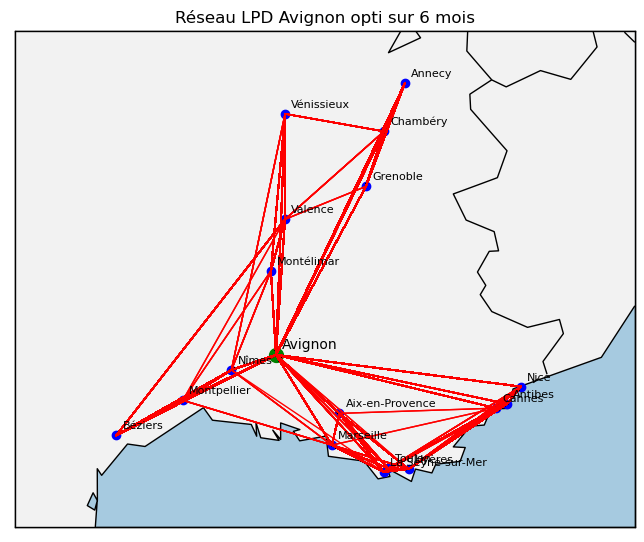

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Créer la carte de France
plt.figure(figsize=(8, 8))
map = Basemap(projection='lcc', resolution='l', width=5E5, height=4E5, lat_0=44.5, lon_0=5.3)

# Tracer les frontières et les côtes de la France
map.drawcoastlines()
map.drawcountries(linewidth=1, color='black')
map.fillcontinents(color='#f2f2f2', lake_color='#8080FF')
map.drawmapboundary(fill_color='#a6cae0')



# Tracer les villes visitées
for i in range(len(cities.city)):
    lat, lon = cities.lat[i], cities.lng[i]
    x, y = map(lon, lat)
    if cities.city[i]=='Avignon':
        plt.plot(x, y, 'go', markersize=10)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=10)
    elif cities.city[i] in liste_villes:
        plt.plot(x, y, 'bo', markersize=6)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=8)
    
# Tracer les trajets réalisés


for k in range(len(trajets_avignon)):
    for i in range(len(trajets_avignon[k])-1):
        start_city, end_city = trajets_avignon[k][i], trajets_avignon[k][i+1]
        start_lat, start_lon = get_latitude(start_city), get_longitude(start_city)
        end_lat, end_lon = get_latitude(end_city), get_longitude(end_city)
        start_x, start_y = map(float(start_lon), float(start_lat))
        end_x, end_y = map(float(end_lon), float(end_lat))
        plt.plot([start_x, end_x], [start_y, end_y], 'r', linewidth=1)
    
# Afficher la carte
plt.title('Réseau LPD Avignon opti sur 6 mois')
plt.show()   

In [105]:
tot_distance_avi_opti = total_dist(trajets_avignon)

In [106]:
tot_distance_avi_opti

1528122.5673719307

In [109]:
orders[orders.from_warehouse == 'Avignon']

,order_id,package_id,package_volume,delivery_location,from_warehouse,order_date,delivered_date,n_units,order_total_volume
0,EtPmaD3APj8aRNeSC3Yx7R,Z8722BWG8WfyrU3jeWsWGo,0.2732,Nice,Avignon,2021-01-01,2021-01-04 00:00:00,27.0,7.3764
23,CxsjqjtWXjpWLNQRf2yxfU,KmBprCffsWobByaWonfSXN,0.0485,Montélimar,Avignon,2021-01-01,2021-01-03 00:00:00,16.0,0.7760
26,YNZmf9oHRh2sNWTftP6bwv,kAh6oD4y4X3RK3zc5BQeo8,0.0020,Montpellier,Avignon,2021-01-01,2021-01-04 00:00:00,10.0,0.0200
28,84yXuzGHV9LXDTjbQDB5Ls,khHNUxYZUEEiRkaVe2FyXg,2.0028,Montélimar,Avignon,2021-01-01,2021-01-11 00:00:00,10.0,20.0280
29,NdwGHuH2mTJgHuh4JjTy7N,KcEQgPTWKrvayEJwmxoquz,0.2433,Toulon,Avignon,2021-01-01,2021-01-05 00:00:00,23.0,5.5959
...,...,...,...,...,...,...,...,...,...
37301,gcEM8tnLKtiPTodH6ZMKqg,khHNUxYZUEEiRkaVe2FyXg,2.0028,Nîmes,Avignon,2021-06-29,NaN,16.0,32.0448
37302,9onNT9y5KmNbwB76KhqpUc,4A8XqQW57uG82xfZ7sjp5F,0.1148,Antibes,Avignon,2021-06-29,NaN,17.0,1.9516
37313,fJ3C5bHbXD9sSnRyus39Q5,2qRALPgMv7KhK4bXqtsNLi,0.0372,Toulon,Avignon,2021-06-29,NaN,20.0,0.7440
37326,ftDJC45goTZSVxBxA8Ejqy,oDvsipheHig4YXYGeUJYqB,0.6944,Nîmes,Avignon,2021-06-29,NaN,14.0,9.7216


In [ ]:
orders

In [28]:
tot_distance_avi_preopti = routes_avi['total_distance'].sum()
tot_distance_avi_preopti

553951.8739275271

In [88]:
lhe=[]
lhe = list(routes_avi.stops)
arr=[]
for k in lhe:
    arr.append(k.split(' > '))

In [89]:
tot_distance_avi_preopti = total_dist(arr)

In [90]:
tot_distance_avi_preopti

553951.1085879998

In [47]:
routes_avi = routes_avi.reset_index(drop=True)

### Diminution km <=> O2

In [26]:
tot_distance_avi_opti

2198588.957375924

In [29]:
tot_distance_avi_opti/tot_distance_avi_preopti

3.9689169057013842

In [30]:
diminution = 1 - tot_distance_avi_opti/tot_distance_avi_preopti
diminution

-2.9689169057013842

### Diminution coûts

# Produit final Cergy

In [11]:
routes_cergy = routes[routes.from_warehouse == 'Cergy']

In [12]:
liste_dates_cergy = routes_cergy['route_date'].tolist()

In [13]:
liste_dates_cergy[2]

'2021-01-03'

In [14]:
list(routes_cergy[routes_cergy.route_date == '2021-01-03'].stops) # ligne qui bug

['Cergy > Épinay-sur-Seine > Versailles > Saint-Maur-des-Fossés > Quimper > Noisy-le-Grand > Neuilly-sur-Seine > Nanterre > Meaux',
 'Cergy > Lorient > Levallois-Perret > Le Mans > Ivry-sur-Seine > Issy-les-Moulineaux > Drancy > Créteil > Courcouronnes > Champigny-sur-Marne > Caen',
 'Cergy > Boulogne-sur-Mer > Boulogne-Billancourt > Antony > Amiens']

In [15]:
tot_distance_cergy_preopti = routes_cergy['total_distance'].sum()
tot_distance_cergy_preopti

1399295.2009418202

Débugage

Fin Débug

In [ ]:
debut = time.time()
trajets_cergy=[]

for d in liste_dates_cergy:
    smol_df = routes_cergy[routes_cergy.route_date == d]
    l=[]
    l = list(smol_df.stops)
    arrets=[]
    for k in l:
        arrets.append(k.split(' > '))
    df_dist, M_dist = arrets_to_matrix(arrets)
    #Début opti
    data = create_data_model(M_dist, 50)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        print('ok')
    else:
        print('No solution found !')
    routes_opti = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(0)  # Ajouter le nœud de départ à la fin de l'itinéraire
        routes_opti.append(route)
    #Fin opti
    routes_opti_num = supprimer_zero(routes_opti)
    routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
    trajets_cergy+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

ok
ok


In [ ]:
debut = time.time()
trajets_cergy=[]

pre_arrets = list(routes_cergy[routes_cergy.route_date == '2021-01-03'].stops)
arrets=[]
for k in pre_arrets:
    arrets.append(k.split(' > '))
df_dist, M_dist = arrets_to_matrix(arrets)
#Début opti
data = create_data_model(M_dist, 50)
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print('ok')
else:
    print('No solution found !')
routes_opti = []
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        index = solution.Value(routing.NextVar(index))
    route.append(0)  # Ajouter le nœud de départ à la fin de l'itinéraire
    routes_opti.append(route)
#Fin opti
routes_opti_num = supprimer_zero(routes_opti)
routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
trajets_cergy+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

In [14]:
trajets_cergy

[['Cergy', 'Saint-Nazaire', 'Cergy'],
 ['Cergy',
  'Boulogne-Billancourt',
  'Issy-les-Moulineaux',
  'Antony',
  'Montreuil',
  'Aubervilliers',
  'Saint-Denis',
  'Amiens',
  'Boulogne-sur-Mer',
  'Caen',
  'Rouen',
  'Cergy']]

In [16]:
test_df = routes_cergy[routes_cergy.route_date == '2021-01-02']
t=[]
t = list(test_df.stops)
t

['Cergy > Saint-Nazaire > Saint-Denis > Rouen > Montreuil > Issy-les-Moulineaux > Caen > Boulogne-sur-Mer',
 'Cergy > Boulogne-Billancourt > Aubervilliers > Antony > Amiens']

# Produit final Montauban

In [70]:
routes_montau = routes[routes.from_warehouse == 'Montauban']

In [71]:
liste_dates_montau = routes_montau['route_date'].tolist()

In [72]:
tot_distance_montau_preopti = routes_montau['total_distance'].sum()
tot_distance_montau_preopti

1399295.2009418202

In [ ]:
debut = time.time()
trajets_montau=[]

for d in liste_dates_montau:
    smol_df = routes_montau[routes_montau.route_date == d]
    l=[]
    l = list(smol_df.stops)
    arrets=[]
    for k in l:
        arrets.append(k.split(' > '))
    df_dist, M_dist = arrets_to_matrix(arrets)
    #Début opti
    data = create_data_model(M_dist, 28)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print('No solution found !')
    routes_opti = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(0)  # Ajouter le nœud de départ à la fin de l'itinéraire
        routes_opti.append(route)
    #Fin opti
    routes_opti_num = supprimer_zero(routes_opti)
    routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
    trajets_montau+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

In [56]:
trajets_montau

[['Avignon', 'Annecy', 'Grenoble', 'Avignon'],
 ['Avignon', 'Vénissieux', 'Montélimar', 'Avignon'],
 ['Avignon', 'Béziers', 'Avignon'],
 ['Avignon', 'Nice', 'Cannes', 'Aix-en-Provence', 'Avignon']]

# Produit final Clermont

In [70]:
routes_clermont = routes[routes.from_warehouse == 'Clermont-Ferrand']

In [71]:
liste_dates_clermont = routes_clermont['route_date'].tolist()

In [72]:
tot_distance_clermont_preopti = routes_clermont['total_distance'].sum()
tot_distance_clermont_preopti

1399295.2009418202

In [ ]:
debut = time.time()
trajets_clermont=[]

for d in liste_dates_clermont:
    smol_df = routes_clermont[routes_clermont.route_date == d]
    l=[]
    l = list(smol_df.stops)
    arrets=[]
    for k in l:
        arrets.append(k.split(' > '))
    df_dist, M_dist = arrets_to_matrix(arrets)
    #Début opti
    data = create_data_model(M_dist, 13)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print('No solution found !')
    routes_opti = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(0)  # Ajouter le nœud de départ à la fin de l'itinéraire
        routes_opti.append(route)
    #Fin opti
    routes_opti_num = supprimer_zero(routes_opti)
    routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
    trajets_clermont+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

In [56]:
trajets_clermont

[['Avignon', 'Annecy', 'Grenoble', 'Avignon'],
 ['Avignon', 'Vénissieux', 'Montélimar', 'Avignon'],
 ['Avignon', 'Béziers', 'Avignon'],
 ['Avignon', 'Nice', 'Cannes', 'Aix-en-Provence', 'Avignon']]

# Produit final Reims

In [70]:
routes_reims = routes[routes.from_warehouse == 'Reims']

In [71]:
liste_dates_reims = routes_reims['route_date'].tolist()

In [72]:
tot_distance_reims_preopti = routes_reims['total_distance'].sum()
tot_distance_reims_preopti

1399295.2009418202

In [ ]:
debut = time.time()
trajets_reims=[]

for d in liste_dates_reims:
    smol_df = routes_reims[routes_cergy.route_date == d]
    l=[]
    l = list(smol_df.stops)
    arrets=[]
    for k in l:
        arrets.append(k.split(' > '))
    df_dist, M_dist = arrets_to_matrix(arrets)
    #Début opti
    data = create_data_model(M_dist, 35)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if not solution:
        print('No solution found !')
    routes_opti = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(0)  # Ajouter le nœud de départ à la fin de l'itinéraire
        routes_opti.append(route)
    #Fin opti
    routes_opti_num = supprimer_zero(routes_opti)
    routes_opti_villes = nb_to_city(routes_opti_num, df_dist)
    trajets_reims+=routes_opti_villes  #la liste de tous les trajets

fin = time.time()
temps_execution = (fin - debut)/60
print("Le temps d'exécution du programme est de : {:.2f} min".format(temps_execution))

In [56]:
trajets_reims

[['Avignon', 'Annecy', 'Grenoble', 'Avignon'],
 ['Avignon', 'Vénissieux', 'Montélimar', 'Avignon'],
 ['Avignon', 'Béziers', 'Avignon'],
 ['Avignon', 'Nice', 'Cannes', 'Aix-en-Provence', 'Avignon']]

# Optimisation

## Partie à automatiser

In [43]:
cities

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper,is_warehouse
0,Paris,48.8566,2.3522,France,FR,Île-de-France,primary,11020000.0,2148271.0,False
1,Nice,43.7034,7.2663,France,FR,Provence-Alpes-Côte d’Azur,minor,1006402.0,341032.0,False
2,Toulouse,43.6045,1.4440,France,FR,Occitanie,admin,968638.0,486828.0,False
3,Marseille,43.2964,5.3700,France,FR,Provence-Alpes-Côte d’Azur,admin,870018.0,868277.0,False
4,Rennes,48.1147,-1.6794,France,FR,Bretagne,admin,727357.0,217728.0,False
...,...,...,...,...,...,...,...,...,...,...
95,Beauvais,49.4303,2.0952,France,FR,Hauts-de-France,minor,56020.0,56020.0,False
96,Maisons-Alfort,48.8058,2.4378,France,FR,Île-de-France,NaN,55655.0,55655.0,False
97,Hyères,43.1199,6.1316,France,FR,Provence-Alpes-Côte d’Azur,NaN,55588.0,55069.0,False
98,Épinay-sur-Seine,48.9553,2.3092,France,FR,Île-de-France,NaN,55084.0,54771.0,False


In [58]:
from geopy import distance

# Coordonnées géographiques des villes
coords = {
    'Avignon': (43.948, 4.808), #0
    'Annecy': (45.8992, 6.1294), #1
    'Vénissieux': (45.697, 4.886), #2
    'Grenoble': (45.1885, 5.7245), #3
    'Montélimar': (44.5599, 4.7517), #4
    'Nice': (43.7034, 7.2663), #5
    'Cannes': (43.5528, 7.0174), #6
    'Aix-en-Provence': (43.5299, 5.4474), #7
    'Béziers': (43.3442, 3.2156) #8
}

# Initialiser la matrice de distances avec des zéros
n = len(coords)
avi_matrix = [[0] * n for _ in range(n)]

# Calculer les distances entre chaque paire de villes
for i, (ville1, coord1) in enumerate(coords.items()):
    for j, (ville2, coord2) in enumerate(coords.items()):
        if i < j:
            dist = distance.distance(coord1, coord2).km
            avi_matrix[i][j] = dist
            avi_matrix[j][i] = dist


## Pas toucher à ça

In [59]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [60]:
def create_data_model(matrix):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = matrix
    data['num_vehicles'] = 45
    data['depot'] = 0
    return data

In [61]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))

In [69]:
data = create_data_model(avi_matrix)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    900,  # vehicle maximum travel distance => pour respecter la limite de 9h de travail par jour (100km/h)
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

# itinéraires de chaque véhicule
routes_opti = []
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        index = solution.Value(routing.NextVar(index))
    routes_opti.append(route)

# Afficher les itinéraires de chaque véhicule
print(routes_opti)

Objective: 49576
Route for vehicle 0:
 0 ->  8 -> 0
Distance of the route: 288km

Route for vehicle 1:
 0 ->  4 ->  2 -> 0
Distance of the route: 388km

Route for vehicle 2:
 0 -> 0
Distance of the route: 0km

Route for vehicle 3:
 0 -> 0
Distance of the route: 0km

Route for vehicle 4:
 0 -> 0
Distance of the route: 0km

Route for vehicle 5:
 0 -> 0
Distance of the route: 0km

Route for vehicle 6:
 0 -> 0
Distance of the route: 0km

Route for vehicle 7:
 0 -> 0
Distance of the route: 0km

Route for vehicle 8:
 0 -> 0
Distance of the route: 0km

Route for vehicle 9:
 0 -> 0
Distance of the route: 0km

Route for vehicle 10:
 0 -> 0
Distance of the route: 0km

Route for vehicle 11:
 0 -> 0
Distance of the route: 0km

Route for vehicle 12:
 0 -> 0
Distance of the route: 0km

Route for vehicle 13:
 0 -> 0
Distance of the route: 0km

Route for vehicle 14:
 0 -> 0
Distance of the route: 0km

Route for vehicle 15:
 0 -> 0
Distance of the route: 0km

Route for vehicle 16:
 0 -> 0
Distance of t

In [70]:
routes_opti

[[0, 8],
 [0, 4, 2],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0, 7, 6, 5],
 [0, 3, 1]]

In [71]:
def supprimer_zero(liste):
    return [sous_liste for sous_liste in liste if any(elem != 0 for elem in sous_liste)]

In [78]:
routes_opti=supprimer_zero(routes_opti)

## Passage à une liste de stops plotable

In [79]:
routes_avignon = []

In [80]:
villes_ordered = ['Avignon', 'Annecy', 'Vénissieux', 'Grenoble', 'Montélimar', 'Nice', 'Cannes', 'Aix-en-Provence', 'Béziers']

In [81]:
routes_opti_villes=[]
l=[]
for k in routes_opti:
    for i in k:
        l.append(villes_ordered[i])
    routes_opti_villes.append(l)
    l=[]
routes_opti_villes

[['Avignon', 'Béziers'],
 ['Avignon', 'Montélimar', 'Vénissieux'],
 ['Avignon', 'Aix-en-Provence', 'Cannes', 'Nice'],
 ['Avignon', 'Grenoble', 'Annecy']]

In [42]:
routes_avignon+=routes_opti_villes

# Visualisation

In [13]:
def get_latitude(city_name):
    latitude = cities.loc[cities['city'] == city_name, 'lat'].iloc[0]
    return latitude

In [16]:
def get_longitude(city_name):
    longitude = cities.loc[cities['city'] == city_name, 'lng'].iloc[0]
    return longitude

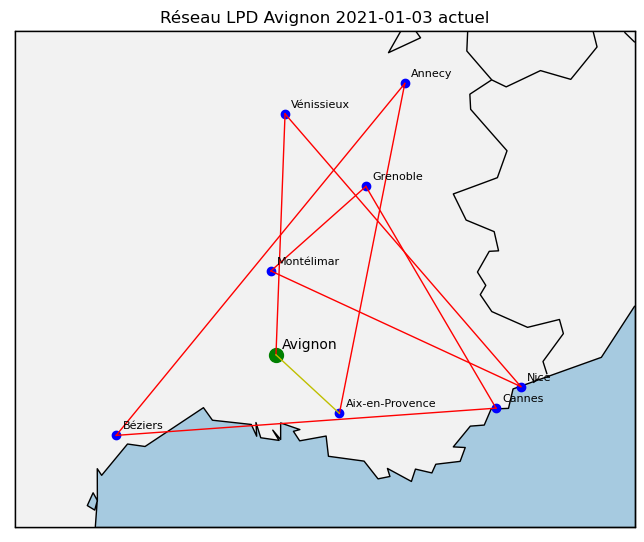

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Créer la carte de France
plt.figure(figsize=(8, 8))
map = Basemap(projection='lcc', resolution='l', width=5E5, height=4E5, lat_0=44.5, lon_0=5.3)

# Tracer les frontières et les côtes de la France
map.drawcoastlines()
map.drawcountries(linewidth=1, color='black')
map.fillcontinents(color='#f2f2f2', lake_color='#8080FF')
map.drawmapboundary(fill_color='#a6cae0')



# Tracer les villes visitées
for i in range(len(cities.city)):
    lat, lon = cities.lat[i], cities.lng[i]
    x, y = map(lon, lat)
    if cities.city[i]=='Avignon':
        plt.plot(x, y, 'go', markersize=10)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=10)
    elif cities.city[i] in villes_sud:
        plt.plot(x, y, 'bo', markersize=6)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=8)
    
# Tracer les trajets réalisés


for i in range(len(routes_a1[0])-1):
    start_city, end_city = routes_a1[0][i], routes_a1[0][i+1]
    start_lat, start_lon = get_latitude(start_city), get_longitude(start_city)
    end_lat, end_lon = get_latitude(end_city), get_longitude(end_city)
    start_x, start_y = map(float(start_lon), float(start_lat))
    end_x, end_y = map(float(end_lon), float(end_lat))
    plt.plot([start_x, end_x], [start_y, end_y], 'r-', linewidth=1)

for i in range(len(routes_a1[1])-1):
    start_city, end_city = routes_a1[1][i], routes_a1[1][i+1]
    start_lat, start_lon = get_latitude(start_city), get_longitude(start_city)
    end_lat, end_lon = get_latitude(end_city), get_longitude(end_city)
    start_x, start_y = map(float(start_lon), float(start_lat))
    end_x, end_y = map(float(end_lon), float(end_lat))
    plt.plot([start_x, end_x], [start_y, end_y], 'y-', linewidth=1)
    
# Afficher la carte
plt.title('Réseau LPD Avignon 2021-01-03 actuel')
plt.show()   

## Meilleur visualisation

In [82]:
villes_sud = ['Avignon', 'Vénissieux', 'Nice', 'Montélimar', 'Grenoble', 'Cannes', 'Béziers', 'Annecy', 'Aix-en-Provence',]

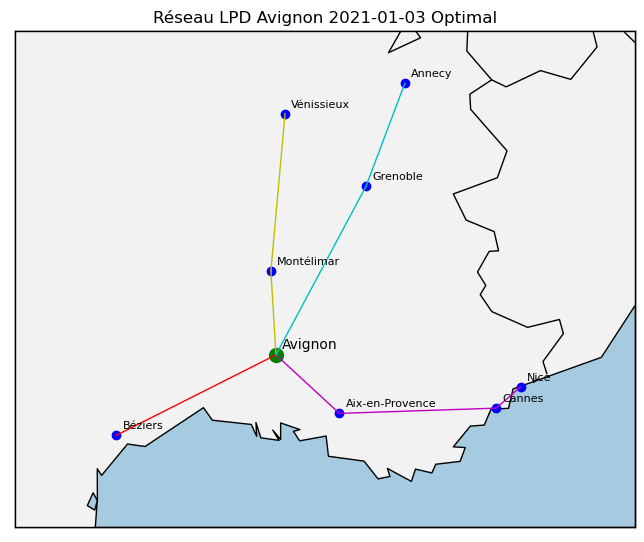

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Créer la carte de France
plt.figure(figsize=(8, 8))
map = Basemap(projection='lcc', resolution='l', width=5E5, height=4E5, lat_0=44.5, lon_0=5.3)

# Tracer les frontières et les côtes de la France
map.drawcoastlines()
map.drawcountries(linewidth=1, color='black')
map.fillcontinents(color='#f2f2f2', lake_color='#8080FF')
map.drawmapboundary(fill_color='#a6cae0')



# Tracer les villes visitées
for i in range(len(cities.city)):
    lat, lon = cities.lat[i], cities.lng[i]
    x, y = map(lon, lat)
    if cities.city[i]=='Avignon':
        plt.plot(x, y, 'go', markersize=10)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=10)
    elif cities.city[i] in villes_sud:
        plt.plot(x, y, 'bo', markersize=6)
        plt.text(x+5000, y+5000, cities.city[i], fontsize=8)
    
# Tracer les trajets réalisés
colors=['r','y','m','c','b','g','k']
for k in range(len(routes_opti_villes)):
    color=colors[k]
    for i in range(len(routes_opti_villes[k])-1):
        start_city, end_city = routes_opti_villes[k][i], routes_opti_villes[k][i+1]
        start_lat, start_lon = get_latitude(start_city), get_longitude(start_city)
        end_lat, end_lon = get_latitude(end_city), get_longitude(end_city)
        start_x, start_y = map(float(start_lon), float(start_lat))
        end_x, end_y = map(float(end_lon), float(end_lat))
        plt.plot([start_x, end_x], [start_y, end_y], color, linewidth=1)

# Afficher la carte
plt.title('Réseau LPD Avignon 2021-01-03 Optimal')
plt.show()   

# Calcul et comparaison des distances/côuts

In [42]:
n=0
for k in routes_a1:
    for i in range(len(k)-1):
        n += disti[k[i]][k[i+1]]
n

2032.061382

In [85]:
n_opti=0
for k in routes_opti_villes:
    for i in range(len(k)-1):
        n_opti += disti[k[i]][k[i+1]]
n_opti

804.423256